# Chapter5. Classification

In [68]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Naive Bayes

The Naive Solution

In [69]:
loandata=pd.read_csv('loan_data.csv.gz')

In [70]:
loandata.head(5)

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [71]:
#convert to categorical
loandata.dtypes

Unnamed: 0             int64
status                object
loan_amnt              int64
term                  object
annual_inc             int64
dti                  float64
payment_inc_ratio    float64
revol_bal              int64
revol_util           float64
purpose               object
home_ownership        object
delinq_2yrs_zero       int64
pub_rec_zero           int64
open_acc               int64
grade                float64
outcome               object
emp_length             int64
purpose_              object
home_                 object
emp_len_              object
borrower_score       float64
dtype: object

In [72]:
loan_data = pd.read_csv('loan_data.csv.gz')

# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)#<-for realworld data
#naive_model = MultinomialNB(alpha=1e-10, fit_prior=False)#<-for uniform probability
naive_model.fit(X, y)

new_loan = X.loc[146:146, :]
print('predicted class: ', naive_model.predict(new_loan)[0])

probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
print(probabilities)

predicted class:  default
predicted probabilities
    default  paid off
0  0.653696  0.346304


In [73]:
new_loan

,credit_card,debt_consolidation,home_improvement,major_purchase,medical,other,small_business,MORTGAGE,OWN,RENT,< 1 Year,> 1 Year
146,0,0,0,0,0,0,1,1,0,0,0,1


There are several situations where applying a uniform probability, or assuming equal prior probabilities for all classes, can be useful:

Lack of prior knowledge: When you have limited or no prior knowledge about the class distribution in the population, assuming uniform prior probabilities can be a reasonable starting point. This avoids introducing bias based on assumptions about the class frequencies.

Balanced classes: If your dataset has a balanced class distribution, where each class is represented by a similar number of instances, assuming uniform prior probabilities can be appropriate. In such cases, all classes are equally likely, and assuming equal priors simplifies the model and can lead to more stable predictions.

Biased training data: If the training data is not representative of the real-world class distribution, assuming uniform prior probabilities can help mitigate the impact of this bias. It ensures that the model does not overly rely on the biased class frequencies observed in the training data.

Class imbalance mitigation: In cases where the dataset has severe class imbalance, where some classes have significantly fewer instances than others, assuming uniform prior probabilities can help prevent the model from favoring the majority class. By treating all classes equally, it forces the model to consider the predictive information in the features rather than relying solely on the class frequencies.

It's important to note that the choice of whether to assume uniform prior probabilities or estimate them from the data depends on the specific problem, the characteristics of the dataset, and domain knowledge. It's often a good practice to evaluate the performance of the model with both approaches and choose the one that yields better results or aligns with the problem requirements.








Y=1인 확률에 따라 레코드들에 순위를 매기는 것이 목적이고 
확률의 비편향된 추정치를 굳이 구할 필요가 없다면, 
나이브 베이즈도 나름 우수한 결과를 보인다

# Linear Discriminant Analysis

S(beta)=(beta mean1-beta mean2)**2/ s1**2+S2**2
optimze to find beta taht maximizes S(beta)

In [74]:
loan3000=pd.read_csv('loan3000.csv')
loan3000.head(5)

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


In [75]:
loan3000.outcome=loan3000.outcome.astype('category')

predictors=['borrower_score','payment_inc_ratio']
outcome='outcome'

X=loan3000[predictors]
y=loan3000[outcome]

loan_lda=LinearDiscriminantAnalysis()
loan_lda.fit(X,y)
print(pd.DataFrame(loan_lda.scalings_,index=X.columns))

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


scaling으로 추정가중치 판별
추정 가중치->변수의 중요도

In [76]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


predict_proba로 예측

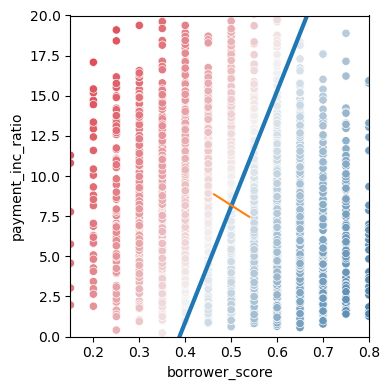

In [77]:
# Use scalings and center of means to determine decision boundary
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df, 
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

# Logistic Regression

Logistic Response Fuction and Logit

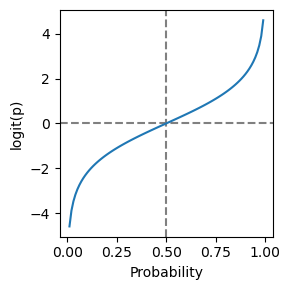

In [78]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()

# Logistic Regression and the GLM(Generalized Linear Model)

In [79]:
loan_data.head(5)

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [80]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  -1.6380884942692562
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079728
borrower_score,4.611037
debt_consolidation,-0.249342
home_improvement,-0.407614
major_purchase,-0.229376
medical,-0.510087
other,-0.620534
small_business,-1.215662
OWN,-0.048453
RENT,-0.157355


penalty: The penalty parameter determines the type of regularization applied to the logistic regression model. Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function. The available options for penalty are 'l1', 'l2', 'elasticnet', and 'none'. In the provided code, 'l2' is specified, which corresponds to L2 regularization, also known as ridge regression.

C: The C parameter controls the inverse of the regularization strength. It defines the trade-off between fitting the training data well and keeping the model's coefficients small. Smaller values of C result in stronger regularization, while larger values of C decrease the regularization strength. In the given code, C is set to a very large value (1e42) which effectively disables regularization.

By setting penalty='l2' and using a large C value, the logistic regression model in the code is performing L2 regularization with a very weak penalty, effectively allowing the model coefficients to take larger values without much regularization influence.

Ridge regression is a variant of linear regression that incorporates L2 regularization. It is designed to handle the problem of multicollinearity (high correlation) among predictor variables and to prevent overfitting.

In traditional linear regression, the goal is to minimize the sum of squared residuals between the predicted values and the actual outcomes. However, when there are highly correlated predictors in the dataset, the linear regression model can become sensitive to small changes in the data, leading to unstable and unreliable coefficient estimates.

Ridge regression addresses this issue by adding a penalty term to the loss function, which is based on the L2 norm (Euclidean norm) of the coefficient vector. The penalty term imposes a constraint on the size of the coefficients, shrinking them towards zero but not exactly to zero.

By including the L2 regularization term, ridge regression encourages the model to distribute the coefficient values more evenly among correlated predictors, reducing their individual impact. This helps to stabilize the model and improve its generalization performance.

The strength of the regularization is controlled by the hyperparameter lambda (λ) or alpha (α), which determines the amount of shrinkage applied to the coefficients. A larger value of lambda/alpha increases the regularization strength, resulting in more pronounced coefficient shrinkage.

Ridge regression is particularly useful when dealing with datasets that have high multicollinearity or when there are more predictors than observations. However, it does not perform variable selection; it shrinks all coefficients towards zero but keeps them non-zero. If you need a method that performs variable selection by setting some coefficients exactly to zero, you can consider using Lasso regression instead, which incorporates L1 regularization.

In [81]:
print(loan_data['purpose_'].cat.categories)
print(loan_data['home_'].cat.categories)
print(loan_data['emp_len_'].cat.categories)

Index(['credit_card', 'debt_consolidation', 'home_improvement',
       'major_purchase', 'medical', 'other', 'small_business'],
      dtype='object')
Index(['MORTGAGE', 'OWN', 'RENT'], dtype='object')
Index([' < 1 Year', ' > 1 Year'], dtype='object')


Not in book : If you have a feature or outcome variable that is ordinal, use the scikit-learn OrdinalEncoder to replace the categories (here, 'paid off' and 'default') with numbers. In the below code, we replace 'paid off' with 0 and 'default' with 1. This reverses the order of the predicted classes and as a consequence, the coefficients will be reversed.

In [82]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

logit_reg_enc = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

print('intercept ', logit_reg_enc.intercept_[0])
print('classes', logit_reg_enc.classes_)
pd.DataFrame({'coeff': logit_reg_enc.coef_[0]}, 
             index=X.columns)

intercept  1.637890901009777
classes [0. 1.]


,coeff
payment_inc_ratio,0.079739
borrower_score,-4.612183
debt_consolidation,0.249414
home_improvement,0.407734
major_purchase,0.229710
medical,0.510744
other,0.620800
small_business,1.214936
OWN,0.048211
RENT,0.157288


# Predicted Values from Logistic Regression

In [83]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean      -0.757850     -0.760423
std        0.378032      0.390419
min       -2.768873     -3.538865
25%       -0.985728     -0.977164
50%       -0.697366     -0.688946
75%       -0.472209     -0.467076
max       -0.029476     -0.064787


In [84]:
pred

,default,paid off
0,-1.416746,-0.277734
1,-1.157066,-0.377472
2,-0.660434,-0.726967
3,-0.531029,-0.886731
4,-0.779537,-0.613630
...,...,...
45337,-0.603036,-0.792190
45338,-0.770400,-0.621437
45339,-0.803675,-0.593629
45340,-1.278947,-0.326188


In [85]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean       0.500001      0.499999
std        0.167336      0.167336
min        0.062733      0.029046
25%        0.373167      0.376377
50%        0.497895      0.502105
75%        0.623623      0.626833
max        0.970954      0.937267


In [86]:
pred

,default,paid off
0,0.242502,0.757498
1,0.314407,0.685593
2,0.516627,0.483373
3,0.588000,0.412000
4,0.458618,0.541382
...,...,...
45337,0.547148,0.452852
45338,0.462828,0.537172
45339,0.447681,0.552319
45340,0.278330,0.721670


# Interpreting the Coefficients and Odds Ratios

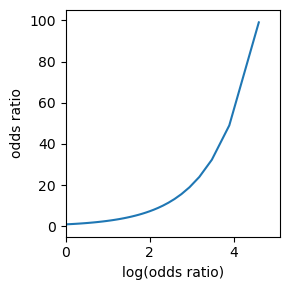

In [87]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5, 105)

plt.tight_layout()
plt.show()

# Assessing the Model

For comparison, here the GLM model using statsmodels. This method requires that the outcome is mapped to numbers. This is to assess features by P value

In [88]:
y_numbers=[1 if yi == 'default' else 0 for yi in y]
logit_reg_sm=sm.GLM(y_numbers, X.assign(const=1),
family=sm.families.Binomial())
logit_result=logit_reg_sm.fit()
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Wed, 24 May 2023   Deviance:                       57515.
Time:                        15:01:01   Pearson chi2:                 4.54e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1112
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0.002     32.058      0.000       0.075       0.085
borrower_score        -4.6126      0.084    -55.203      0.000      -4.776      -4.449
debt_consolidation     0.2494      0.028      9.030      0.000       0.195       0.303
home_improvement       0.4077      0.047      8.747      0.000       0.316       0.499
major_purchase         0.2296      0.054      4.277      0.000       0.124       0.335
medical                0.5105      0.087      5.882      0.000       0.340       0.681
other                  0.6207      0.039     15.738      0.000       0.543       0.698
small_business         1.2153      0.063     19.192      0.000       1.091       1.339
OWN                    0.0483      0.038      1.271      0.204      -0.026       0.123
RENT                   0.1573      0.021      7.420      0.000       0.116       0.199
 > 1 Year             -0.3567      0.053     -6.779      0.000      -0.460      -0.254
const                  1.6381      0.074     22.224      0.000       1.494       1.783
======================================================================================
"""

In [89]:
# Assuming you have the logistic regression model 'logit_result' and the actual observed values 'y_numbers'

predicted_probabilities = logit_result.predict()  # Get the predicted probabilities from the logistic regression model
predicted_classes = [1 if prob >= 0.5 else 0 for prob in predicted_probabilities]  # Apply a threshold of 0.5 to classify the predictions

# Compare the predicted classes with the actual observed values to count the number of wrong predictions
wrong_predictions = sum([1 for pred, actual in zip(predicted_classes, y_numbers) if pred != actual])

print("Number of wrong predictions:", wrong_predictions)


Number of wrong predictions: 16483


In [90]:
loan_data.shape

(45342, 21)

In [91]:
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45321
Model Family:                                       Binomial   Df Model:                           20
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28731.
Date:                                       Wed, 24 May 2023   Deviance:                       57462.
Time:                                               15:01:01   Pearson chi2:                 4.54e+04
No. Iterations:                                            6   Pseudo R-squ. (CS):             0.1122
Covariance Type:                                   nonrobust                      

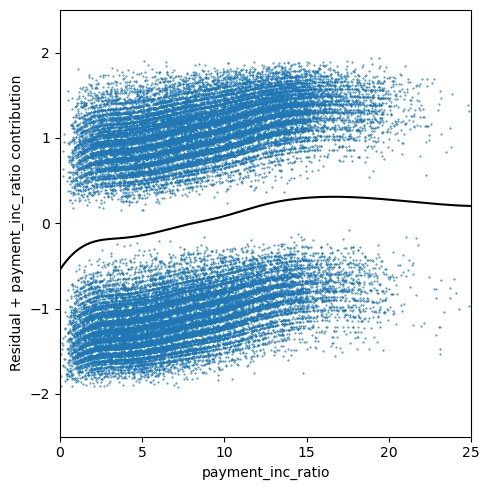

In [92]:
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)


plt.tight_layout()
plt.show()

# Evaluating Classification Models

Confusion Matrix

In [93]:
# Confusion matrix
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])

conf_mat

,Yhat = default,Yhat = paid off
Y = default,14336,8335
Y = paid off,8148,14523


In [94]:

classificationSummary(y, logit_reg.predict(X), 
                      class_names=logit_reg.classes_)

Confusion Matrix (Accuracy 0.6365)

         Prediction
  Actual  default paid off
 default    14336     8335
paid off     8148    14523


In [95]:
confusion_matrix(y, logit_reg.predict(X))

array([[14336,  8335],
       [ 8148, 14523]], dtype=int64)

# Precision, Recall, and Specificity

In [96]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precision', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('Recall', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Specificity', conf_mat[1, 1] / sum(conf_mat[1, :]))

Precision 0.6376089663760897
Recall 0.6323496978518812
Specificity 0.6405981209474659


precision<-true pos/true pos+false pos\
Recall<-true pos/true pos+false neg\
Specificity<-true neg/true neg+false pos

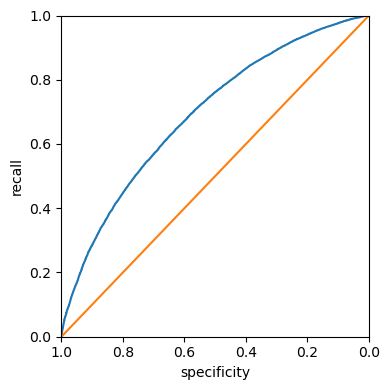

In [97]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')


plt.tight_layout()
plt.show()

# AUC

Area underneath the Curve:if AUC is 1, it means that that is no case where 0 is predicted as 1 and 1 is predicted as 1 for 100%

In [98]:
print(np.sum(roc_df.recall[:-1]*np.diff(1-roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y],
                   logit_reg.predict_proba(X)[:,0]))

0.691710795288669
0.6917108731135808


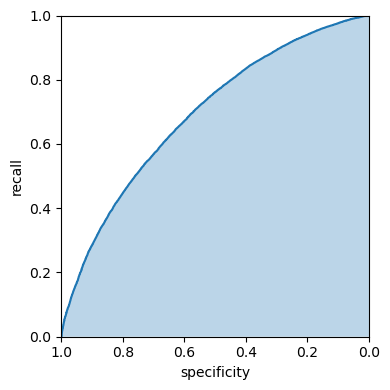

In [99]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

# Strategies for Imbalanced Data

Undersampling

downsampling can balance data between 0 and 1

In [100]:
full_train_set=pd.read_csv('full_train_set.csv.gz')
full_train_set.head(5)

,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_
0,Fully Paid,5000,36 months,24000,27.65,8.14350,13648.0,83.7,credit_card,RENT,1,1,3,5.4,paid off,11,credit_card,RENT,> 1 Year
1,Charged Off,2500,60 months,30000,1.00,2.39320,1687.0,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year
2,Fully Paid,2400,36 months,12252,8.72,8.25955,2956.0,98.5,small_business,RENT,1,1,2,5.0,paid off,11,small_business,RENT,> 1 Year
3,Fully Paid,10000,36 months,49200,20.00,8.27585,5598.0,21.0,other,RENT,1,1,10,4.2,paid off,11,other,RENT,> 1 Year
4,Fully Paid,5000,36 months,36000,11.20,5.21533,7963.0,28.3,wedding,RENT,1,1,9,6.8,paid off,4,other,RENT,> 1 Year


In [101]:
print('percentage of loans in default:',
     100*np.mean(full_train_set.outcome=='default'))

percentage of loans in default: 18.894546909248504


full_train_set.outcome=='default' creates a boolean Series with True values where the "outcome" column in the full_train_set DataFrame is equal to 'default', and False otherwise.

np.mean() calculates the mean of the boolean Series. In this case, since True is treated as 1 and False as 0, the mean will represent the proportion of True values in the Series.

Multiplying the result by 100 will convert the proportion to a percentage.

In [108]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

X=pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='',
                drop_first=True)
y=full_train_set[outcome]

full_model=LogisticRegression(penalty='l2',C=1e42,solver='liblinear')
full_model.fit(X,y)

print('percentage of loans predicted to default: ', 
100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to default:  1.0059423104169618


In [103]:
pred=full_model.predict(X)
pd.DataFrame(pred)

,0
0,paid off
1,paid off
2,paid off
3,paid off
4,paid off
...,...
119982,paid off
119983,paid off
119984,paid off
119985,paid off


연체데이터가 극단적으로 적어서 예측값도 다 대출을 갚았다고 나옴

# Oversampling and Up/Down Weighting

다수 클래스를 과소표본추출하는 대신, 희귀 클래스의 데이터를 과잉표본추출(부트스트래핑)혹은 데이터에 가중치를 적용

In [109]:
default_wt=1/np.mean(full_train_set.outcome=='default')
wt=[default_wt if outcome=='default' else 1 for outcome in full_train_set.outcome]

full_model=LogisticRegression(penalty='l2',C=1e42,solver='liblinear')
full_model.fit(X,y,wt)

print('percentage of loans predicted to default (weighting): ', 
100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to default (weighting):  61.05911473742989


연제에 대한 가중치 1/p p는 연체의 확률값, 대출 상환에 개한 가중치는 1. 연체와 상환의 가중치 합은 거의 동일

# Data Generation

합성소수과잉표본기법(synthetic minority oversampling technique)은 업샘플링된 레코드와 비슷한 레코드를 찾고 원래 레코드와 이웃 레코드의 랜덤 가중평균으로 새로운 합성래코드를 만든다. 여기에 대해 각각의 예측변수에 대해 개별적으로 가중치를 생성한다.The package imbalanced-learn provides an implementation of the SMOTE and similar algorithms.

In [112]:
X_resampled, y_resampled=SMOTE().fit_resample(X,y)
print('percentage of loans in default (SMOTE resampled):',
     200*np.mean(y_resampled=='default'))

full_model=LogisticRegression(penalty='l2', C=1e42,solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (SMOTE): ', 
      100 * np.mean(full_model.predict(X) == 'default'))

X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print('percentage of loans in default (ADASYN resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (ADASYN): ', 
     100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans in default (SMOTE resampled): 100.0
percentage of loans predicted to default (SMOTE):  29.441522831640093
percentage of loans in default (ADASYN resampled):  48.56040383751355
percentage of loans predicted to default (ADASYN):  27.497145524098443


기대수익=P(Y=0)*R+P(Y=1)*C  where R=revenue by being paid off C=cost of default

가치가 적은 대출보다는 연체 확률이 더 높더라도 가치가 더 큰 대출을 선호하는 편이 나을 수도 있다.

In [116]:
loan3000 = pd.read_csv('loan3000.csv')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', 
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

logit_reg = LogisticRegression(penalty="l2", solver='liblinear')
logit_reg.fit(X, y)


## model
gam = LinearGAM(s(0) + s(1))
print(gam.gridsearch(X.values, [1 if yi == 'default' else 0 for yi in y]))

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)


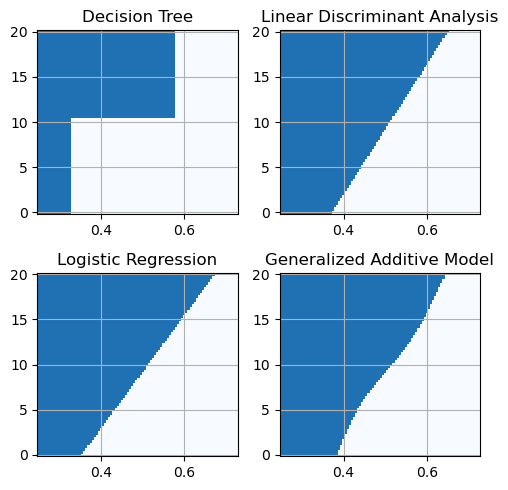

In [117]:
models = {
    'Decision Tree': loan_tree,
    'Linear Discriminant Analysis': loan_lda,
    'Logistic Regression': logit_reg,
    'Generalized Additive Model': gam,
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

xvalues = np.arange(0.25, 0.73, 0.005)
yvalues = np.arange(-0.1, 20.1, 0.1)
xx, yy = np.meshgrid(xvalues, yvalues)
X = pd.DataFrame({
    'borrower_score': xx.ravel(),
    'payment_inc_ratio': yy.ravel(),
})

boundary = {}

for n, (title, model) in enumerate(models.items()):
    ax = axes[n // 2, n % 2]
    predict = model.predict(X)
    if 'Generalized' in title:
        Z = np.array([1 if z > 0.5 else 0 for z in predict])
    else:
        
        Z = np.array([1 if z == 'default' else 0 for z in predict])
    Z = Z.reshape(xx.shape)
    boundary[title] = yvalues[np.argmax(Z > 0, axis=0)]
    boundary[title][Z[-1,:] == 0] = yvalues[-1]

    c = ax.pcolormesh(xx, yy, Z, cmap='Blues', vmin=0.1, vmax=1.3, shading='auto')
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

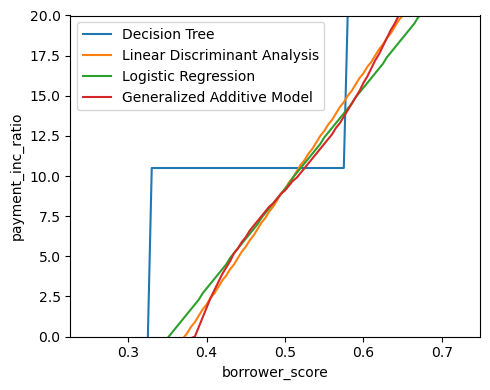

In [118]:

boundary['borrower_score'] = xvalues
boundaries = pd.DataFrame(boundary)

fig, ax = plt.subplots(figsize=(5, 4))
boundaries.plot(x='borrower_score', ax=ax)
ax.set_ylabel('payment_inc_ratio')
ax.set_ylim(0, 20)


plt.tight_layout()
plt.show()